# Принятие решений в бизнесе. A/B-тест.

Наша команда аналитиков вместе с отделом маркетинга крупного интернет-магазина подготовили список гипотез. Задачи проекта — приоритизировать гипотезы и проанализировать результаты A/B-теста. В нашем распоряжении имеются данные:

* 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort,
* результаты A/B-теста (2 датафрейма: orders и visitors).


# План работы

**1. Загрузка данных и подготовка их к анализу.**

* Посмотреть первые строки
* Обработать пропуски
* Обработать дубликаты
* Посмотреть на тип данных столбцов

**2. Приоритизация гипотез.**

* Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

**3. Анализ A/B-теста.**

* Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
* Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
* Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
* Построить график кумулятивного среднего количества заказов на посетителя по группам. Сделать выводы и предположения.
* Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделать выводы и предположения.
* Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
* Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
* Построить точечный график стоимостей заказов. Сделать выводы и предположения.
* Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
* Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.

**4. Общий вывод**

* Написать выводы и принять решение по результатам теста. Варианты решений: 
    * Остановить тест, зафиксировать победу одной из групп. 
    * Остановить тест, зафиксировать отсутствие различий между группами. 
    * Продолжить тест.

# Описание данных

**Структура <code>hypothesis.csv</code>:**

* <code>Hypothesis</code> — краткое описание гипотезы,
* <code>Reach</code> — охват пользователей по 10-балльной шкале,
* <code>Impact</code> — влияние на пользователей по 10-балльной шкале,
* <code>Efforts</code> — уверенность в гипотезе по 10-балльной шкале.

**Структура <code>orders.csv</code>:**

* <code>transactionId</code> — идентификатор заказа,  
* <code>visitorId</code> — идентификатор пользователя, совершившего заказ,
* <code>date</code> — дата, когда был совершён заказ,
* <code>revenue</code> — выручка заказа,
* <code>group</code> — группа A/B-теста, в которую попал заказ.

**Структура <code>visitors.csv</code>:**

* <code>date</code> — дата,
* <code>group</code> — группа A/B-теста,
* <code>visitors</code> — количество пользователей в указанную дату в указанной группе A/B-теста.

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
 
register_matplotlib_converters()

In [2]:
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )


except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv')
    )

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.3f}'.format

display(hypothesis)
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [3]:
# Общая информация о датафреймe hypothesis.csv

hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
# Общая информация о датафреймe orders.csv

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
# Общая информация о датафреймe visitors.csv

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Заметим, что нужно привести названия столбцов к змеимному стилю и переименовать, столбы с датой и временем привести к верному формату, проверить датафреймы дубликаты. Пропуски отсутствуют.

In [6]:
# Понизим регистр названий столбцов в hypothesis и orders

hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()

# Переименуем столбцы в orders

orders = orders.rename(columns={'transactionid':'transaction_id', 
                                'visitorid':'visitor_id'
                               })

# Приведем столбцы с датой и временем к нужному формату в датафреймах orders и visitors

orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

# Проверим датафреймы orders и visitors на наличие дубликатов

print(f'Количество дубликатов в датафрейме orders: {orders.duplicated().sum()}')
print(f'Количество дубликатов в датафрейме visitors: {visitors.duplicated().sum()}')


Количество дубликатов в датафрейме orders: 0
Количество дубликатов в датафрейме visitors: 0


In [7]:
# найдем количество исследуемых групп
print(f'Количество исследуемых групп в таблице orders: {orders["group"].nunique()}')
print(f'Количество исследуемых групп в таблице visitors: {visitors["group"].nunique()}')

# посчитаем количество неникальных пользователей в каждой группе c помощью count (для уникальных - nunique)
display(orders.groupby("group").agg({"visitor_id":"count"}))

# посчитаем минимальную и максимальную даты исследования
print(f'Минимальная дата исследования: {orders["date"].min()}')
print(f'Максимальная дата исследования: {orders["date"].max()}')

# проверим есть ли пользователи, попавшие в обе группы
orders_grouped = orders.groupby(['visitor_id']).agg({'group': 'nunique'}).query('group > 1')
print(f'Количество пользователей, попавших в обе группы: {orders_grouped.shape[0]}')

Количество исследуемых групп в таблице orders: 2
Количество исследуемых групп в таблице visitors: 2


,visitor_id
group,
A,557
B,640


Минимальная дата исследования: 2019-08-01 00:00:00
Максимальная дата исследования: 2019-08-31 00:00:00
Количество пользователей, попавших в обе группы: 58


Теперь данные готовы к анализу.

### Приоритизация гипотез

* Применить фреймворк <code>ICE</code> для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Применить фреймворк <code>RICE</code> для приоритизации гипотез. Отсортировать их по убыванию приоритета.
* Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

#### Применение фреймворка  <code>ICE</code>  для приоритизации гипотез

In [8]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Наиболее перспективные гипотезы:
* 8: Запустить акцию, дающую скидку на товар в день рождения
* 0: Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* 7: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* 6: Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
* 2: Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

#### Применение фреймворка  <code>RICE</code>  для приоритизации гипотез

In [9]:
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


Снова самые перспективные: 8, 0, 7, 6, 2. Однако они в другом порядке, так получилось, потому что добавился параметр Reach, который учитывает обхват пользователей. У 7-ой гипотезы он равен 10, поэтому она на первом месте.

### Анализ A/B-теста

* Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
* Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
* Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
* Построить график кумулятивного среднего количества заказов на посетителя по группам. Сделать выводы и предположения.
* Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделать выводы и предположения.
* Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
* Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
* Построить точечный график стоимостей заказов. Сделать выводы и предположения.
* Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
* Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделать выводы и предположения.
* Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм <code>cumulativeData</code> со столбцами:

* <code>date</code> — дата;
* <code>group</code> — группа A/B-теста (A или B);
* <code>orders</code> — кумулятивное количество заказов на указанную дату в указанной группе;
* <code>buyers</code> — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
* <code>revenue</code> — кумулятивная выручка на указанную дату в указанной группе (средний чек);
* <code>visitors</code> — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [10]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

display(cumulativeData.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


#### График кумулятивной выручки по группам

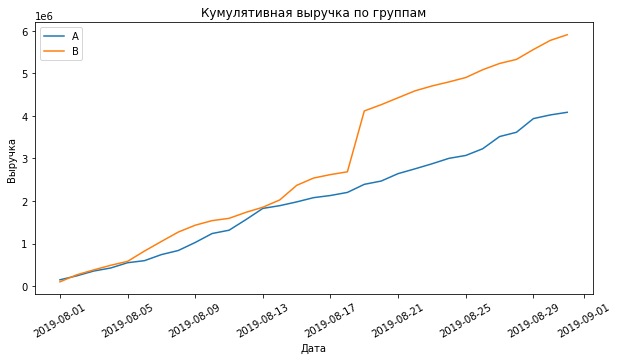

In [11]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# строим график выручки группы А
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.legend()
plt.show;

Отметим, что выручка группы A стабильно растет и проигрывает группе B. У группы B наблюдается резкий скачок 19-20 августа. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

#### График кумулятивного среднего чека по группам

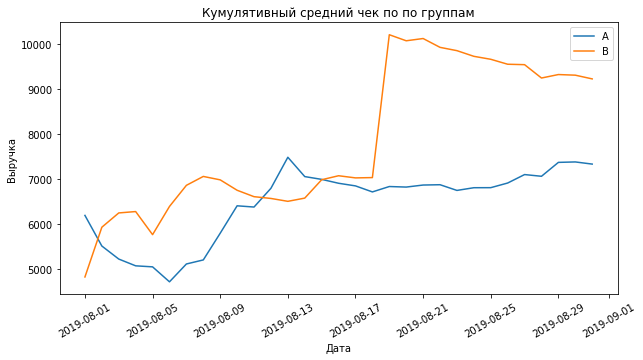

In [12]:
# разделим кумулятивную выручку на кумулятивное число заказов
# строим график выручки группы А
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')


plt.title('Кумулятивный средний чек по по группам')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.legend()
plt.show;

Оба графика заметно колебались, однако средний чек в группе A стабилизировался, что нельзя сказать о группе B. Судя по скачку в графике, в выборке реально могли оказаться крупные закакзы.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

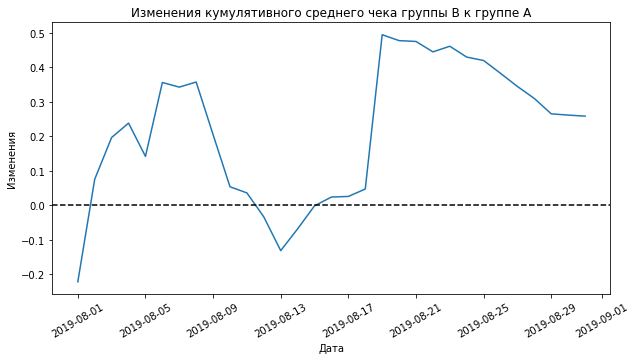

In [13]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', 
                                                   right_on='date', 
                                                   how='left', 
                                                   suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/
          mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel('Изменения')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.show;

График резко скачет, что говорит нам о выбросах и о крупных заказах.

#### График кумулятивного среднего количества заказов на посетителя по группам

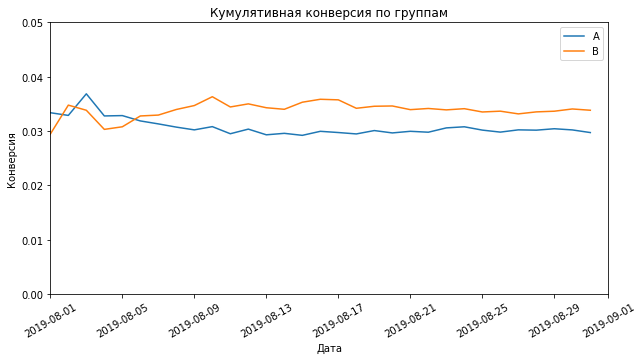

In [14]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(10,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])

plt.title('Кумулятивная конверсия по группам')
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.legend()
plt.show;

В начале графики колебались и группа A имела большую конверсию, но после того как графики стабилизировались, мы видим, что сегмент B больше значения сегмента A.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

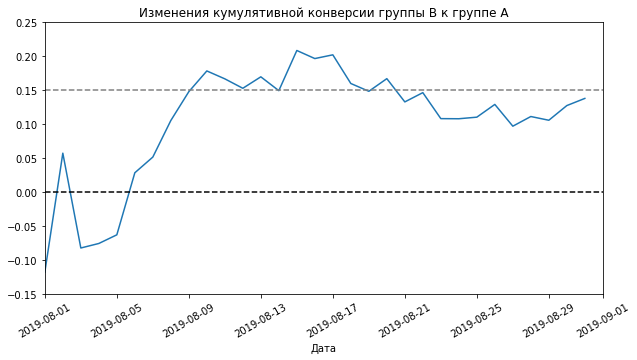

In [15]:
# собираем данные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['A', 'B'])

# строим график
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1)

# добавляем оси X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.15, 0.25]) 

plt.title('Изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.show;

В начале конверсия группы B проигрывала группе А, затем резко вырвалась вперед и начала колебаться вокруг прироста в 15%. В целом отношение конверсии ещё не установилось, сперва стоит проанализировать аномалии.

#### Точечный график количества заказов по пользователям

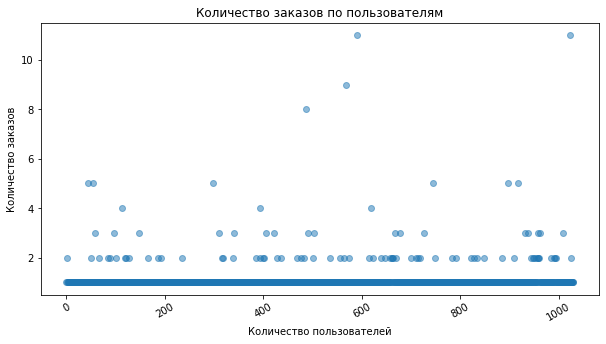

In [16]:
# сгруппируем по пользователям и посчитаем количество заказов
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

# построим график
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(10,5))
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5)

plt.title('Количество заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей')
plt.xticks(rotation=30)
plt.show;


В основном пользователи делают 1 заказ, непонятно можно ли считать пользователей с 2-3 заказами аномалиями. Стоит посчитать перцентили.

In [17]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше чем 2 заказа. И 1% пользователей заказывали более 4 раз. Выберем 4 заказа одного пользователя за верхнюю границу числа заказов.

#### Точечный график стоимостей заказов

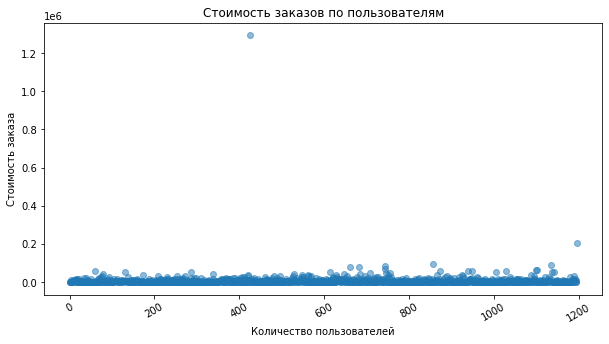

In [18]:
# построим график
x_values = pd.Series(range(0,len(orders['revenue'])))


plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], alpha=0.5)

plt.title('Стоимость заказов по пользователям')
plt.ylabel('Стоимость заказа')
plt.xlabel('Количество пользователей')
plt.xticks(rotation=30)
plt.show;

Прочесть график мешают 2 аномальных значения. Установим ограничение на ось y, чтобы график стал читаемым.

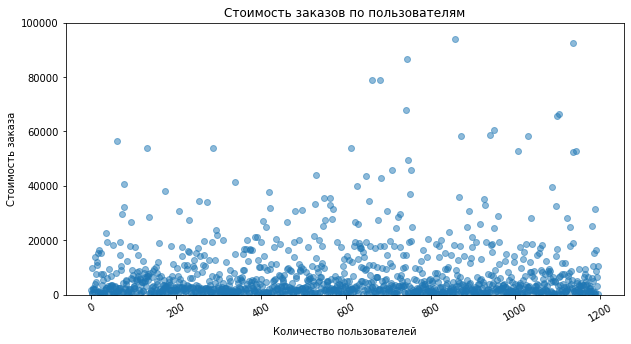

In [19]:
# построим график с ограничением на ось y
plt.figure(figsize=(10,5))
plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'], alpha=0.5)

plt.title('Стоимость заказов по пользователям')
plt.ylabel('Стоимость заказа')
plt.xlabel('Количество пользователей')
plt.xticks(rotation=30)
plt.show;

В основном стоимость заказов от 20000 до 60000. Рассчитаем перцентили, чтобы установить верхнюю границу стоимости заказов.

In [20]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более 5% пользователей оформляли заказы на сумму больше чем 28000. И 1% пользователей заказывали на больше чем 58233. Выберем 58233 за верхнюю границу стоимости заказов.

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Мы оценили результаты A/B-теста визуально и выяснили, что в данных, скорее всего, есть аномалии. Увидели выбросы и нашли границу для их определения. Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей. Сформулируем гипотезы:

* $H_{0}$: различий в среднем количестве заказов между группами нет
* $H_{1}$: различия в среднем между группами есть

Подготовим данные:

In [21]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Мы получили таблицу <code>data</code> со столбцами:

* <code>date</code> — дата,
* <code>ordersPerDateA</code> — количество заказов в выбранную дату в группе A,
* <code>revenuePerDateA</code> — суммарная выручка в выбранную дату в группе A,
* <code>ordersPerDateB</code> — количество заказов в выбранную дату в группе B,
* <code>revenuePerDateB</code> — суммарная выручка в выбранную дату в группе B,
* <code>ordersCummulativeA</code> — суммарное число заказов до выбранной даты включительно в группе A,
* <code>revenueCummulativeA</code> — суммарная выручка до выбранной даты включительно в группе A,
* <code>ordersCummulativeB</code> — суммарное количество заказов до выбранной даты включительно в группе B,
* <code>revenueCummulativeB</code> — суммарная выручка до выбранной даты включительно в группе B,
* <code>visitorsPerDateA</code> — количество пользователей в выбранную дату в группе A,
* <code>visitorsPerDateB</code> — количество пользователей в выбранную дату в группе B,
* <code>visitorsCummulativeA</code> — количество пользователей до выбранной даты включительно в группе A,
* <code>visitorsCummulativeB</code> — количество пользователей до выбранной даты включительно в группе B,

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.
Создадим переменные <code>ordersByUsersA</code> и <code>ordersByUsersB</code> со столбцами <code>['userId', 'orders']</code>. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [22]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

Объявим переменные <code>sampleA</code> и <code>sampleB</code>, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [23]:
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(
                         0, 
                         index=np.arange(data['visitorsPerDateA'].sum() - 
                                         len(ordersByUsersA['orders'])), 
                         name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(
                         0, 
                         index=np.arange(data['visitorsPerDateB'].sum() - 
                                         len(ordersByUsersB['orders'])), 
                         name='orders')],axis=0)

Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой. Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1.  Округлим до трёх знаков после запятой.

In [24]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#зададим уровень значимости
alpha = 0.05
p_value = stats.mannwhitneyu(sampleA, sampleB)[1]
print("p-value: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

print("Относительный прирост В к А: {0:.1%}".format(sampleB.mean() / sampleA.mean()-1))

p-value: 0.017
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 13.8%


По «сырым» данным в среднем числе заказов групп A и B есть различие. p-value = меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8%.

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Сформулируем гипотезы:

* $H_{0}$: различий в среднем чеке между группами нет
* $H_{1}$: различия в среднем чеке между группами есть

In [25]:
alpha = 0.05
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print("p-value: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

print("Относительный прирост В к А: {0:.1%}".format(orders[orders['group']=='B']['revenue'].mean()/
                                                    orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.9%


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако средний чек группы B на 25.9% выше среднего чека группы A.

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Напомним, что пользователей совершивших покупки на сумму более 58 233 или совершивших больше 4 заказов мы приняли за аномальных. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — <code>usersWithManyOrders</code> и пользователей, совершивших заказы дороже 58 233 — <code>usersWithExpensiveOrders</code>. Объединим их в таблице <code>abnormalUsers</code>. 
Узнаем, сколько всего аномальных пользователей атрибутом <code>shape</code>.

In [26]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58233]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
print('Количество аномальных пользователей:', abnormalUsers.shape[0]) 

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

Количество аномальных пользователей: 15


Всего 15 аномальных пользователей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [27]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Сформулируем гипотезы:

* $H_{0}$: различий в среднем количестве заказов между группами нет
* $H_{1}$: различия в среднем между группами есть


In [28]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
print("p-value: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

print("Относительный прирост В к А: {0:.1%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.014
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 15.3%


Результаты по среднему количеству заказов практически не изменились. Конверсия выросла на 2%.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы:
    
* $H_{0}$: различий в среднем чеке между группами нет
* $H_{1}$: различия в среднем чеке между группами есть

In [29]:
alpha = 0.05
p_value = stats.mannwhitneyu(orders[(orders['group']=='A') & 
                                    np.logical_not(orders['visitor_id'].isin(abnormalUsers))]['revenue'], 
                             orders[(orders['group']=='B') & 
                                    np.logical_not(orders['visitor_id'].isin(abnormalUsers))]['revenue'])[1]

print("p-value: {0:.3f}".format(p_value))

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

print("Относительный прирост В к А: {0:.1%}".format((orders[(orders['group']=='B') & 
                                    np.logical_not(orders['visitor_id'].isin(abnormalUsers))]['revenue'].mean())/
                                                    (orders[(orders['group']=='A') & 
                                    np.logical_not(orders['visitor_id'].isin(abnormalUsers))]['revenue'].mean())-1))

p-value: 0.851
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -0.6%


P-value увеличился, но разница между сегментами сократилась с 25.9% до -0.6%, группы примерно на одном уровне.

### Общий вывод

Коллегам следует обратить внимание на следующие гипотезы (от самой приоритетной к менее приоритетной):

* Запустить акцию, дающую скидку на товар в день рождения
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

Если коллеги учитывают охват пользователей, то следует обратить внимание на гипотезы в следующем порядке:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
* Запустить акцию, дающую скидку на товар в день рождения
    
    


Результаты A/B теста:

* Имеется статистически значимое различие в среднем количестве заказов на посетителя между группами по «сырым» данным и по «чистым». На «сырых» данных конверсия группы B выше конверсии группы А на 13.8%. На отфильтрованных данных конверсия B выше на 15.3%. 
* Нет статистически значимого различия по среднему чеку между группами по «сырым» данным и по «чистым». Однако средний чек группы B относительно группы A упал c 25.9% до -0.06%.
* Кумулятивная конверсия группы B выше конверсии группы A на 15%. Нет никаких оснований полагать, что она будет ниже.

Мы рекомендуем остановить тест и зафиксировать победу группы B. 
